# Classification & NER Model

In [31]:
# Imports
import torch
import pickle
import pandas as pd
import seaborn as sns
import nltk
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import Trainer, TrainingArguments
import nlpaug.augmenter.word as naw
import random
from nltk.corpus import stopwords
import string
from textblob import Word

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import spacy
nlp = spacy.load('en_core_web_sm')

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/shaswatgarg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/shaswatgarg/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [32]:
# Import the stopwords module from NLTK and retrieve the list of common English stopwords
stop_words = stopwords.words('english')  # <-- don't overwrite the module name!

# Add custom stopwords to the list to include words that should be ignored during text processing
custom_stopwords = ["n\'t", "\'s", ".", "—"]

# Extend the existing stop_words list with the custom stopwords
stop_words.extend(custom_stopwords)


## Task 1: Sentence Classification

In [33]:
# Load the classification dataset from a CSV file into a DataFrame
classification_df = pd.read_csv("datasets/classification_data.csv")

# Remove duplicate rows based on the 'text' column to ensure each text is unique
classification_df = classification_df.drop_duplicates(subset='text')

# Display the first few rows of the DataFrame to inspect the data
classification_df.head()

,id,text,label
0,1,DrugZ caused severe rashes in some participants.,Adverse Effect
1,2,No significant side effects were observed duri...,Positive Outcome
2,3,Participants were monitored every two weeks.,Neutral Observation
3,4,Increased liver enzymes were noted post-treatm...,Adverse Effect
4,5,Patients were instructed to maintain a food di...,Neutral Observation


<AxesSubplot: xlabel='label', ylabel='count'>

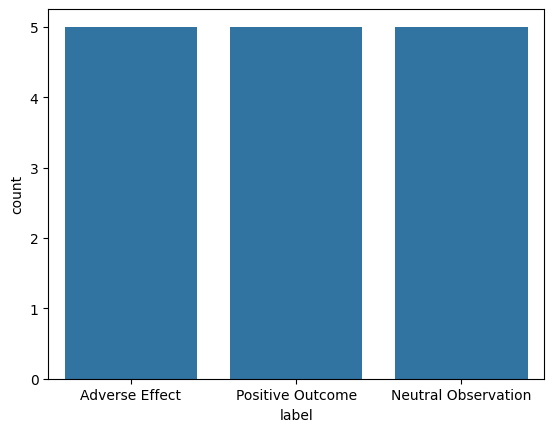

In [34]:
# Barchart/ count plot - To check if there's class balance 
sns.countplot(data=classification_df, x='label')

'\nAdverse Effect sentences mostly cluster around lengths 7 and 8.\nNeutral Observation has strong peaks at lengths 7 and 8.\nPositive Outcome sentences appear longer on average, peaking around lengths 9 to 10.\n'

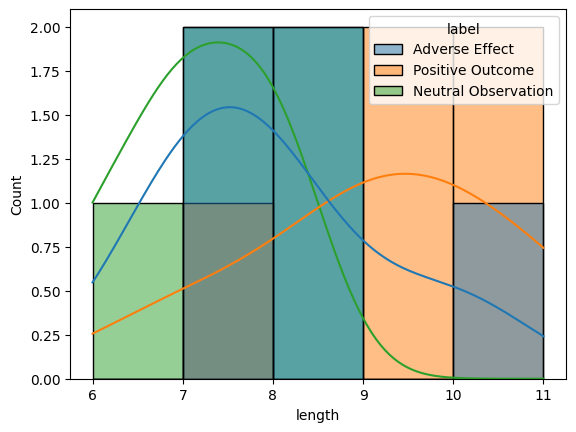

In [35]:
# Histogram/ KDE - Understand sentence complexity (Reveals if certain classes tend to have longer/shorter sentences)
classification_df['length'] = classification_df['text'].apply(lambda x: len(x.split()))
sns.histplot(data=classification_df, x='length', hue='label', kde=True)

'''
Adverse Effect sentences mostly cluster around lengths 7 and 8.
Neutral Observation has strong peaks at lengths 7 and 8.
Positive Outcome sentences appear longer on average, peaking around lengths 9 to 10.
'''

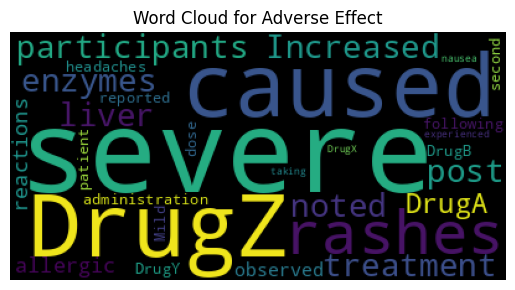

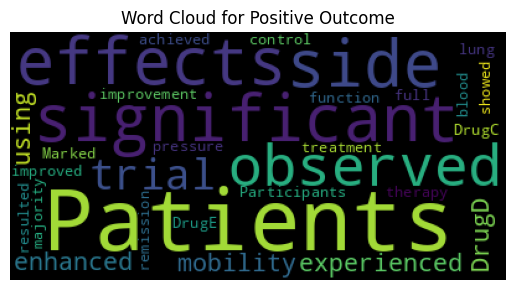

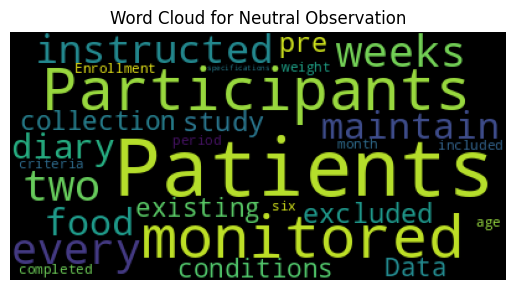

In [36]:
# Word cloud per class - Identify common words and themes
for label in classification_df['label'].unique():
    text = ' '.join(classification_df[classification_df['label'] == label]['text'])
    wc = WordCloud().generate(text)
    plt.imshow(wc)
    plt.title(f"Word Cloud for {label}")
    plt.axis('off')
    plt.show()

In [37]:
'''
ContextualWordEmbsAug – uses BERT for contextual augmentation
SynonymAug – replaces words with synonyms using WordNet
RandomWordAug – random insert/delete/swap
'''

# Initialize the synonym augmenter, using WordNet for synonym-based augmentation
syn_aug = naw.SynonymAug(aug_src='wordnet', aug_min=1, aug_max=3)

# Initialize the contextual word embeddings augmenter using BERT for fast contextual augmentation
contextual_aug = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased',  # BERT model path for contextual augmentation
    action="insert",  # Action to perform (insert new words)
    top_k=10,  # Top K candidate words to insert
    #device='cuda' if torch.cuda.is_available() else 'cpu'  # Uncomment if using GPU (optional)
)

# Initialize the random word augmenter to perform random word insertions, deletions, or swaps
swap_aug = naw.RandomWordAug(action="swap")

# List of augmenters to randomly choose from for text augmentation
aug_list = [swap_aug]  # You can add other augmenters (like syn_aug) here

# Lists to store the augmented texts and their corresponding labels
augmented_texts = []
augmented_labels = []

# Loop through the dataset and apply augmentation to each text
for index, row in classification_df.iterrows():
    try:
        # Randomly choose an augmenter from the list
        aug = random.choice(aug_list)
        
        # Augment the text; `n=3` means generate 3 variations for each original text
        augmented = aug.augment(row['text'], n=3)
        
        # Append the augmented texts and corresponding labels to the lists
        for aug_text in augmented:
            augmented_texts.append(aug_text)
            augmented_labels.append(row['label'])  # Same label as original text
    except Exception as e:
        # Print error message if an exception occurs during augmentation
        print(f"Error augmenting row {index}: {e}")

# Create a new DataFrame with the augmented texts and labels
aug_df = pd.DataFrame({'text': augmented_texts, 'label': augmented_labels})

# Combine the original DataFrame with the augmented DataFrame
combined_df = pd.concat([classification_df, aug_df]).reset_index(drop=True)

# Print the shape of the combined DataFrame (original + augmented data)
print(combined_df.shape)


(60, 4)


In [38]:
def clean(doc):
    """
    Cleans and preprocesses the input document by:
    - Removing named entities (such as names and places).
    - Removing extra spaces and punctuation.
    - Lowercasing the text.
    - Lemmatizing the words in the text.
    """
    # Initialize a list to store text without named entities
    text_no_namedentities = []
    
    # Process the document with spaCy for Named Entity Recognition (NER)
    document = nlp(doc)
    
    # Extract named entities from the document
    ents = [e.text for e in document.ents]
    
    # Iterate through each token in the document
    for item in document:
        # If the token is a named entity, we skip it (do not include in the result)
        if item.text in ents:
            pass
        else:
            text_no_namedentities.append(item.text)  # Add non-entity token to the list

    # Join the remaining tokens (without named entities) into a string
    doc = (" ".join(text_no_namedentities))
    
    # Remove extra spaces and join words properly
    doc = ' '.join(doc.split()).strip()
    print('+++', doc)  # Print the document for debugging purposes

    # Convert the text to lowercase
    doc = doc.lower()
    
    # Optional: Remove certain HTML tags or punctuation
    doc = doc.replace("</br>", " ")  # Replace line breaks with space
    doc = doc.replace("-", " ")  # Replace hyphens with space
    
    # Remove punctuation and digits from the document
    doc = "".join([char for char in doc if char not in string.punctuation and not char.isdigit()])
    
    # Lemmatize each word in the document to reduce it to its base form
    # Instead of using NLTK's Lemmatizer, using TextBlob here
    doc = "".join([Word(word).lemmatize() for word in doc])
    
    # Return the cleaned and preprocessed document
    return doc


In [39]:
# Apply the `clean` function to each row in the 'text' column of the combined DataFrame
combined_df['text'] = combined_df['text'].apply(clean)

# Display the first few rows of the DataFrame after the cleaning process
combined_df.head()

+++ caused severe rashes in some participants .
+++ No significant side effects were observed during the trial .
+++ Participants were monitored every two weeks .
+++ Increased liver enzymes were noted post - treatment with DrugA.
+++ Patients were instructed to maintain a food diary .
+++ Patients experienced enhanced mobility after using DrugD.
+++ Participants showed improved lung function after therapy with DrugC.
+++ The study excluded patients with pre - existing conditions .
+++ Severe allergic reactions were observed following DrugB administration .
+++ Marked improvement in blood pressure control was achieved with DrugE.
+++ Mild headaches were reported after the dose of DrugY.
+++ The patient experienced nausea after taking DrugX.
+++ The treatment resulted in full remission for the majority of patients .
+++ Data collection was completed over a six - month period .
+++ Enrollment criteria included age and weight specifications .
+++ caused severe DrugZ rashes some in partici

,id,text,label,length
0,1.0,caused severe rashes in some participants,Adverse Effect,7.0
1,2.0,no significant side effects were observed duri...,Positive Outcome,9.0
2,3.0,participants were monitored every two weeks,Neutral Observation,6.0
3,4.0,increased liver enzymes were noted post trea...,Adverse Effect,8.0
4,5.0,patients were instructed to maintain a food di...,Neutral Observation,8.0


<AxesSubplot: xlabel='length', ylabel='Count'>

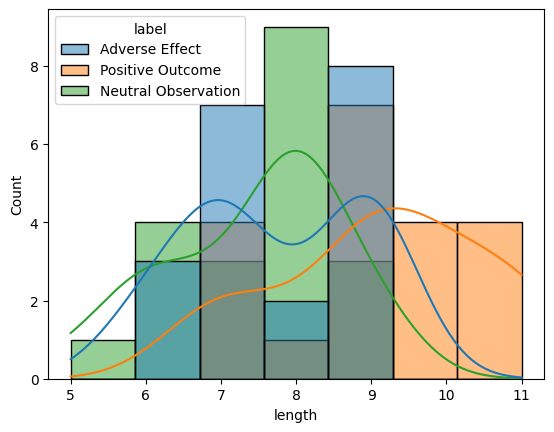

In [40]:
# Histogram/ KDE - Understand sentence complexity (Reveals if certain classes tend to have longer/shorter sentences)
combined_df['length'] = combined_df['text'].apply(lambda x: len(x.split()))
sns.histplot(data=combined_df, x='length', hue='label', kde=True)

In [41]:
# Encode Labels
label_encoder = LabelEncoder()
combined_df['label_encoded'] = label_encoder.fit_transform(combined_df['label'])

In [42]:
# 1. Split into train + test (80% train, 20% temp)
train_texts, test_texts, train_labels, test_labels = train_test_split(
    combined_df['text'].tolist(),
    combined_df['label'].tolist(),
    test_size=0.2,
    stratify=combined_df['label'],
    random_state=42
)

In [43]:
# Import the necessary modules from Hugging Face's Transformers library
from transformers import (
    DistilBertTokenizerFast,  # Tokenizer class for DistilBERT model
    DistilBertForSequenceClassification,  # Model class for sequence classification using DistilBERT
)

# Load the pre-trained DistilBERT tokenizer for tokenizing the input text
# 'distilbert-base-uncased' is the pre-trained DistilBERT model in lowercase
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


In [44]:
# Tokenize the training texts using the pre-loaded DistilBERT tokenizer.
# 'truncation=True' ensures that texts longer than the model's maximum input length are truncated.
# 'padding=True' adds padding to the texts to make them the same length (to the longest text or the model's maximum length).
train_encodings = tokenizer(train_texts, truncation=True, padding=True)

# Tokenize the test texts similarly to ensure consistent preprocessing for evaluation.
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


In [45]:
# Dataset Class
torch.backends.cuda.matmul.allow_tf32 = True

In [46]:
# Define a custom dataset class for classification using PyTorch's Dataset
class ClassificationDataset(torch.utils.data.Dataset):
    
    # Initialization method to store encodings and labels
    def __init__(self, encodings, labels):
        # Store the tokenized input encodings and corresponding labels
        self.encodings = encodings
        self.labels = labels

    # Method to retrieve a single data sample by index
    def __getitem__(self, idx):
        # Convert the input encodings to PyTorch tensors
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        
        # Add the label as a tensor
        item['labels'] = torch.tensor(self.labels[idx])
        
        # Return the sample in the required format: {'input_ids': tensor, 'attention_mask': tensor, 'labels': tensor}
        return item

    # Method to return the size of the dataset (number of samples)
    def __len__(self):
        return len(self.labels)  # The number of samples is the same as the number of labels


In [47]:
# Import LabelEncoder from scikit-learn to encode string labels into integers
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder instance to encode labels
label_encoder = LabelEncoder()

# Encode the training labels from strings to integers
train_labels = label_encoder.fit_transform(train_labels)

# Encode the test labels using the same mapping from the training labels
test_labels = label_encoder.transform(test_labels)

# Create the training dataset by passing the tokenized inputs (train_encodings) and encoded labels (train_labels)
train_dataset = ClassificationDataset(train_encodings, train_labels)

# Create the test dataset by passing the tokenized inputs (test_encodings) and encoded labels (test_labels)
test_dataset = ClassificationDataset(test_encodings, test_labels)


In [48]:
# Load the pre-trained DistilBERT model for sequence classification
# 'distilbert-base-uncased' is the pre-trained model, and 'num_labels' specifies the number of target classes.
# The number of labels is derived from the length of the unique labels in the label encoder's classes
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

# Print the model configuration to inspect the model's parameters and setup
print(model.config)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.45.2",
  "vocab_size": 30522
}



In [49]:
# Define the training arguments for model training
training_args = TrainingArguments(
    output_dir="/tmp/results",  # Directory where the results (model checkpoints, logs) will be saved
    evaluation_strategy="no",  # Perform evaluation at the end of each epoch
    learning_rate=5e-5,  # Learning rate for optimization
    per_device_train_batch_size=16,  # Batch size per device (GPU/CPU) for training
    per_device_eval_batch_size=16,  # Batch size per device (GPU/CPU) for evaluation
    num_train_epochs=30,  # Total number of epochs to train the model
    weight_decay=0.001,  # Weight decay (regularization) to prevent overfitting
    logging_dir="/tmp/logs",  # Directory to store logs for monitoring training
    logging_steps=10,  # Log training information every 10 steps
    save_strategy="no",  # Save the model at the end of each epoch
    load_best_model_at_end=True,  # Load the best model after training based on evaluation metric
    warmup_steps=500,  # Number of steps to linearly increase the learning rate (for better stability at the beginning)
)

/opt/homebrew/lib/python3.9/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [50]:
# Define a function to compute evaluation metrics (accuracy and F1 score) during training and evaluation
def compute_metrics(pred):
    # Extract the true labels and the predicted labels from the prediction object
    labels = pred.label_ids  # True labels (ground truth)
    preds = pred.predictions.argmax(-1)  # Predicted labels by taking the argmax (highest probability)

    # Calculate the accuracy score between the true labels and the predicted labels
    acc = accuracy_score(labels, preds)

    # Calculate the F1 score, using the 'macro' average
    f1 = f1_score(labels, preds, average='macro')

    # Return the computed metrics in a dictionary format
    return {
        'accuracy': acc,  # Accuracy metric
        'f1': f1,  # F1 score metric
    }


In [51]:
# Initialize the Trainer for model training and evaluation
trainer = Trainer(
    model=model,  # The model to be trained (DistilBERT model for sequence classification)
    args=training_args,  # The training arguments that define the training process (e.g., batch size, epochs)
    train_dataset=train_dataset,  # The dataset for training
    compute_metrics=compute_metrics  # The function to compute metrics like accuracy and F1 score
)

# Start the training process
trainer.train()


 13%|█▎        | 12/90 [00:01<00:08,  9.16it/s]

{'loss': 1.0943, 'grad_norm': 1.67766535282135, 'learning_rate': 1.0000000000000002e-06, 'epoch': 3.33}


 23%|██▎       | 21/90 [00:02<00:08,  8.36it/s]

{'loss': 1.0818, 'grad_norm': 1.6932052373886108, 'learning_rate': 2.0000000000000003e-06, 'epoch': 6.67}


 34%|███▍      | 31/90 [00:03<00:06,  9.16it/s]

{'loss': 1.0701, 'grad_norm': 1.6341475248336792, 'learning_rate': 3e-06, 'epoch': 10.0}


 47%|████▋     | 42/90 [00:04<00:05,  9.21it/s]

{'loss': 1.0403, 'grad_norm': 1.643576979637146, 'learning_rate': 4.000000000000001e-06, 'epoch': 13.33}


 57%|█████▋    | 51/90 [00:05<00:05,  7.76it/s]

{'loss': 0.9801, 'grad_norm': 2.0672249794006348, 'learning_rate': 5e-06, 'epoch': 16.67}


 68%|██████▊   | 61/90 [00:07<00:03,  9.05it/s]

{'loss': 0.8805, 'grad_norm': 2.921487808227539, 'learning_rate': 6e-06, 'epoch': 20.0}


 80%|████████  | 72/90 [00:08<00:01,  9.44it/s]

{'loss': 0.762, 'grad_norm': 2.8746659755706787, 'learning_rate': 7.000000000000001e-06, 'epoch': 23.33}


 90%|█████████ | 81/90 [00:09<00:01,  8.50it/s]

{'loss': 0.5898, 'grad_norm': 2.4904518127441406, 'learning_rate': 8.000000000000001e-06, 'epoch': 26.67}


100%|██████████| 90/90 [00:10<00:00,  8.69it/s]

{'loss': 0.4287, 'grad_norm': 1.9470534324645996, 'learning_rate': 9e-06, 'epoch': 30.0}
{'train_runtime': 10.3305, 'train_samples_per_second': 139.393, 'train_steps_per_second': 8.712, 'train_loss': 0.8808346748352051, 'epoch': 30.0}


100%|██████████| 90/90 [00:11<00:00,  7.95it/s]


TrainOutput(global_step=90, training_loss=0.8808346748352051, metrics={'train_runtime': 10.3305, 'train_samples_per_second': 139.393, 'train_steps_per_second': 8.712, 'total_flos': 5215996840320.0, 'train_loss': 0.8808346748352051, 'epoch': 30.0})

In [52]:
# Save the trained model to a specified directory (e.g., "my_model")
trainer.save_model("my_model")  # Saves the model's state_dict, configuration, and any additional files needed for loading the model later

# Save the label encoder to a pickle file for later use in encoding/decoding labels
pickle.dump(label_encoder, open('label_encoder.sav', 'wb'))

In [53]:
# Get model predictions on the test dataset using the trainer
# The `predict()` method returns a `PredictionOutput` object which includes the predictions, label ids, and metrics
preds_output = trainer.predict(test_dataset)

# The `predictions` attribute contains raw model outputs (logits), so we need to apply argmax to get the predicted class labels
preds = torch.argmax(torch.tensor(preds_output.predictions), dim=1)

# Print the predicted labels and the full output of the `predict()` method for inspection
print(preds)  # Prints the predicted class labels for the test dataset
print(preds_output)  # Prints the full prediction output, including logits, label_ids, and other metrics

# Calculate accuracy and F1 score for model evaluation
# Accuracy: The proportion of correctly classified samples
accuracy = accuracy_score(test_labels, preds)

# F1 Score: The harmonic mean of precision and recall, averaged using macro method
f1 = f1_score(test_labels, preds, average='macro')

# Print the computed evaluation metrics
print(f"Accuracy: {accuracy:.4f}")  # Display accuracy with 4 decimal places
print(f"F1 Score (weighted): {f1:.4f}")  # Display F1 score with 4 decimal places


100%|██████████| 1/1 [00:00<00:00, 250.69it/s]

tensor([0, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 0])
PredictionOutput(predictions=array([[ 1.3852882 , -0.97159207, -0.5766978 ],
       [-0.5034005 , -0.47735757,  0.871321  ],
       [-0.4201853 ,  1.0701584 , -0.3274288 ],
       [-0.4781218 ,  0.98571837, -0.38843647],
       [-0.49449632, -0.6005846 ,  0.96992147],
       [ 1.1911731 , -0.8595193 , -0.585906  ],
       [-0.41639268, -0.49858692,  1.0175616 ],
       [ 1.2892139 , -1.0226868 , -0.5301508 ],
       [-0.50665736,  1.1594545 , -0.3237925 ],
       [-0.5801761 ,  1.1226345 , -0.47946745],
       [-0.15471923, -0.69139916,  0.75944114],
       [ 1.2115555 , -0.915078  , -0.5786752 ]], dtype=float32), label_ids=array([0, 2, 1, 1, 2, 0, 2, 0, 1, 1, 2, 0]), metrics={'test_loss': 0.33806076645851135, 'test_accuracy': 1.0, 'test_f1': 1.0, 'test_runtime': 0.1458, 'test_samples_per_second': 82.304, 'test_steps_per_second': 6.859})
Accuracy: 1.0000
F1 Score (weighted): 1.0000


In [54]:
# New example sentences for model inference
new_sentences = [
    "The patient experienced severe nausea after medication.",
    "The results were consistent with previous measurements.",
    "Patient recovered fully and showed improved mobility.",
    "The subject exhibited mild dizziness following the treatment.",
    "The individual showed significant improvement in their condition.",
    "The patient reported a reduction in pain after taking the medication.",
    "The study results were documented, and the methodology was reviewed.", 
    "The patient’s medical history was updated in the hospital records.", 
    "The individual experienced intense headaches and vomiting following the medication.", 
    "The subject complained of severe dizziness and blurred vision after the medication."
]

# Tokenize the new sentences using the pre-trained tokenizer
# 'truncation=True' ensures sentences longer than the model's maximum input length are truncated.
# 'padding=True' adds padding to make all sentences the same length (based on the longest sentence or max length).
new_encodings = tokenizer(new_sentences, truncation=True, padding=True, return_tensors="pt")

# Get the device (either 'cpu', 'cuda', or 'mps' based on available hardware)
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device (GPU/CPU/MPS)
model.to(device)

# Move the tokenized inputs to the same device as the model (ensures model and inputs are on the same device)
new_encodings = {key: val.to(device) for key, val in new_encodings.items()}

# Set the model to evaluation mode (disables dropout and other training-specific behavior)
model.eval()

# Perform inference (no gradient calculation needed, as we're just predicting)
with torch.no_grad():  # Prevent gradients from being calculated to save memory and computation
    # Get model outputs (logits) for the new sentences
    outputs = model(**new_encodings)

    # Get the predicted class labels by taking the argmax of the logits
    predictions = torch.argmax(outputs.logits, dim=1)

# Decode the predicted labels (transform them back to their original string values using the label encoder)
decoded_preds = label_encoder.inverse_transform(predictions.cpu().numpy())

# Show the sentences with their predicted labels
for sentence, label in zip(new_sentences, decoded_preds):
    print(f"{sentence} → {label}")  # Print each sentence with its predicted label

The patient experienced severe nausea after medication. → Adverse Effect
The results were consistent with previous measurements. → Positive Outcome
Patient recovered fully and showed improved mobility. → Positive Outcome
The subject exhibited mild dizziness following the treatment. → Adverse Effect
The individual showed significant improvement in their condition. → Positive Outcome
The patient reported a reduction in pain after taking the medication. → Adverse Effect
The study results were documented, and the methodology was reviewed. → Neutral Observation
The patient’s medical history was updated in the hospital records. → Neutral Observation
The individual experienced intense headaches and vomiting following the medication. → Adverse Effect
The subject complained of severe dizziness and blurred vision after the medication. → Adverse Effect
